In [127]:
# load the library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import date
from math import log, sqrt, exp, isclose
from scipy.stats import lognorm, norm
from scipy.integrate import quad
from scipy.optimize import fsolve
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import sys
sys.path.append(r"C:\Users\WANGLIN CAI\fintech545")
import RiskManagement as RM




In [128]:
# calculate the time to maturity
current_day = date(2023,3,3)
expiration_day = date(2023,3,17)
days_to_mat = (expiration_day - current_day).days
# calendar days
ttm = days_to_mat / 365
print("Time to Maturity is {:.4f}".format(ttm))

Time to Maturity is 0.0384


In [129]:
# define a function to calculate option values with BLack Scholes Formula
def bs_model(underlying, strike, ttm, rf, b, implied_vol, security_type="call"):
    d1 = (log(underlying/strike) + (b+implied_vol**2/2)*ttm)/(implied_vol*sqrt(ttm))
    d2 = d1 - implied_vol*sqrt(ttm)

    if security_type == "call":
        return underlying * exp((b-rf)*ttm) * norm.cdf(d1) - strike*exp(-rf*ttm)*norm.cdf(d2)
    elif security_type == "put":
        return strike*exp(-rf*ttm)*norm.cdf(-d2) - underlying*exp((b-rf)*ttm)*norm.cdf(-d1)
    else:
        print("Invalid type of option")

In [130]:
# initialize the problem, assuming that both strikes for put option and call option would be 165
underlying = 165
strike = 165
rf = 0.0425
coupon = 0.0053
b = rf - coupon
implied_vol = np.linspace(0.1, 0.8, 200)

bs_model_call_values = np.zeros(len(implied_vol))
bs_model_put_values = np.zeros(len(implied_vol))


In [131]:
# start the calculation of call values, and checking if call values derived from two methods are close
for i in range(len(implied_vol)):
    bs_model_call_values[i] = bs_model(underlying, strike, ttm, rf, b, implied_vol[i], security_type="call")
    bs_model_put_values[i] = bs_model(underlying, strike, ttm, rf, b, implied_vol[i], security_type="put")

# checking put call parity
result = True
for i in range(len(bs_model_call_values)):
    if isclose(bs_model_call_values[i] + strike * exp(-rf*ttm), bs_model_put_values[i] + underlying, abs_tol = 0.1) == False:
        result = False
print(result)


True


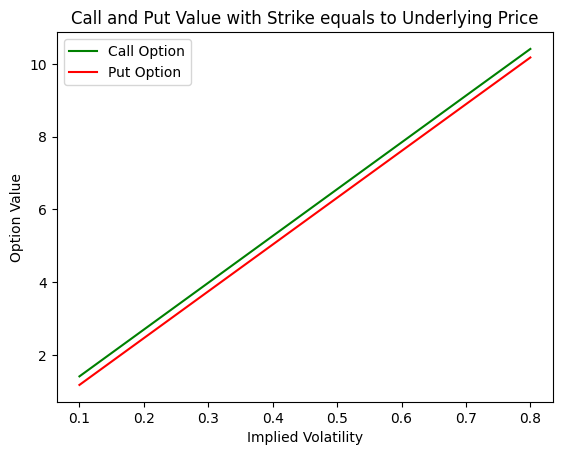

In [132]:
# ploting values of put and call options with impied vols ranging from 0.1 to 0.8
plt.figure()
plt.plot(implied_vol, bs_model_call_values, label="Call Option", color = 'green')
plt.plot(implied_vol, bs_model_put_values, label="Put Option", color = 'red')
plt.xlabel("Implied Volatility")
plt.ylabel("Option Value")
plt.legend()
plt.title("Call and Put Value with Strike equals to Underlying Price")
plt.show()

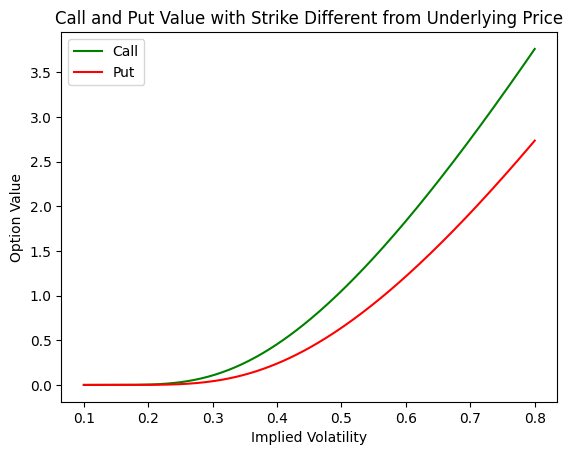

In [138]:

# check what will happen if strike prices become difference for puts and calls
bs_model_call_values_diff = np.zeros(len(implied_vol))
bs_model_put_values_diff = np.zeros(len(implied_vol))

for i in range(len(implied_vol)):
    bs_model_call_values_diff[i] = bs_model(underlying, strike+20, ttm, rf, b, implied_vol[i], security_type="call")
    bs_model_put_values_diff[i] = bs_model(underlying, strike-20, ttm, rf, b, implied_vol[i], security_type="put")

# ploting values of put and call options with impied vols ranging from 0.1 to 0.8
plt.figure()
plt.plot(implied_vol, bs_model_call_values_diff, label="Call", color = 'green')
plt.plot(implied_vol, bs_model_put_values_diff, label="Put", color = 'red')
plt.xlabel("Implied Volatility")
plt.ylabel("Option Value")
plt.legend()
plt.title("Call and Put Value with Strike Different from Underlying Price")
plt.show()

In [ ]:
# q2

In [30]:
# change working directory
os.chdir(r'C:\Users\WANGLIN CAI\fintech545\Week06')

In [31]:
current_day = date(2023,3,3)
rf = 0.0425
coupon = 0.0053
b = rf - coupon
underlying = 151.03

In [32]:
# read in data
data = pd.read_csv("AAPL_Options.csv")
expiration = data["Expiration"]
option_type = data["Type"]
strike = data["Strike"]
price = data["Last Price"]
implied_vol = np.zeros(len(data))

In [54]:
data

,Stock,Expiration,Type,Strike,Last Price,implied_vol
0,AAPL,4/21/2023,Call,125,27.300,0.374597
1,AAPL,4/21/2023,Call,130,22.575,0.342351
2,AAPL,4/21/2023,Call,135,17.750,0.292522
3,AAPL,4/21/2023,Call,140,13.850,0.299358
4,AAPL,4/21/2023,Call,145,9.975,0.278743
5,AAPL,4/21/2023,Call,150,6.700,0.263141
6,AAPL,4/21/2023,Call,155,4.050,0.246828
7,AAPL,4/21/2023,Call,160,2.210,0.235242
8,AAPL,4/21/2023,Call,165,1.035,0.223567
9,AAPL,4/21/2023,Call,170,0.460,0.219339


In [36]:
# start calculating implied volatility
for i in range(len(data)):
    year =  int(expiration[i].split("/")[2])
    month = int(expiration[i].split("/")[0])
    day = int(expiration[i].split("/")[1])
    # define a function so that we could find roots later
    f = lambda ivol: bs_model(underlying, int(strike[i]), 
                              (date(int(expiration[i].split("/")[2]), int(expiration[i].split("/")[0]), int(expiration[i].split("/")[1])) - current_day).days/365, 
                              rf, 
                              b, 
                              ivol, 
                              security_type=option_type[i].lower()) - float(price[i])
    implied_vol[i] = fsolve(f,0.5)
    
data["implied_vol"] = implied_vol

In [ ]:
# extract call and put data from the combine dataframe
call = data.loc[data["Type"]=="Call"]
put = data.loc[data["Type"]=="Put"]

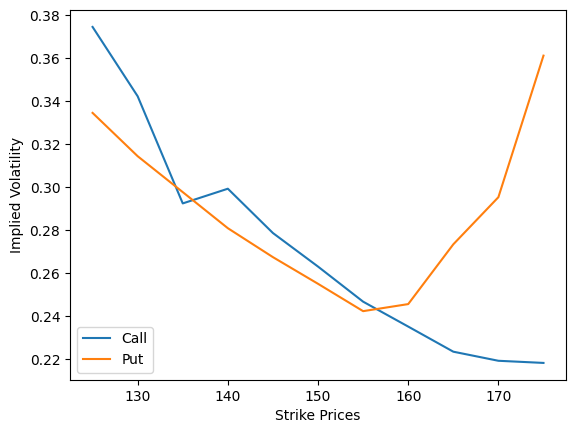

In [55]:
# plot graphs of implied volatility with respect to strike prices
plt.figure()
#plt.plot(strike, implied_vol, label="All Options")
plt.plot(call.Strike, call.implied_vol, label="Call")
plt.plot(put.Strike, put.implied_vol, label="Put")
plt.xlabel("Strike Prices")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

In [141]:
# calculate log returns of prices of Apple Stock with defined function in my function library
prices = pd.read_csv("DailyPrices.csv")
aapl_prices = prices["AAPL"]
log_aapl_prices = np.log(aapl_prices)
aapl_mean = np.mean(log_aapl_prices)
aapl_std = np.std(log_aapl_prices)
np.random.seed(0)
log_normal_prices = norm(aapl_mean,aapl_std).rvs(10000)
lreturns = RM.return_calculate(prices, method="LOG", dateColumn="Date")
aapl_lreturns = lreturns["AAPL"]


C:\Users\WANGLIN CAI\fintech545\RiskManagement\return_calculate.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]


In [61]:
aapl_lreturns

1      0.022888
2     -0.001390
3     -0.021499
4     -0.009400
5     -0.017973
         ...   
244    0.024107
245   -0.018091
246    0.019062
247   -0.017810
248   -0.006936
Name: AAPL, Length: 248, dtype: float64

In [57]:
# randomly draw from the log returns of Apple stock following a normal distribution
mean = np.mean(aapl_lreturns)
std = np.std(aapl_lreturns)
normal_lreturns = norm(mean, std).rvs(10000)


In [62]:
mean, std

(-0.0004365167234339716, 0.022380778943343265)

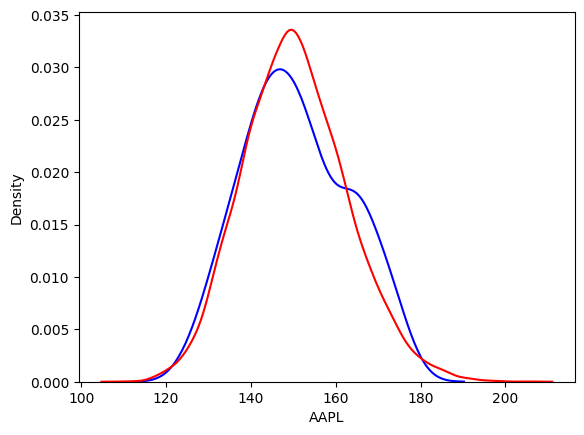

In [142]:
# plot both distributions
plt.figure()
sns.kdeplot(aapl_prices, color="b", label='Actual Returns')
sns.kdeplot(np.e**log_normal_prices, color="r", label='Simulated')
plt.show()

In [149]:
# q3
### PART 1 ###
# define a function to simulate portfolio values with simulated prices
def sim_portfolio_value(portfolio, sim_p, ivol, rf, b, day_passed=0):
    sim_values = pd.DataFrame(index=portfolio.index, columns=list(range(sim_p.shape[0])))
    for i in portfolio.index:
        if portfolio["Type"][i] == "Stock":
            individual_value = sim_p
        else:
            underlying_p = sim_p
            strike = portfolio["Strike"][i]
            ttm = ((portfolio["ExpirationDate"][i] - datetime(2023,3,3)).days - day_passed) / 365
            individual_value = np.zeros(len(underlying_p))
            for z in range(len(underlying_p)):
                individual_value[z] = bs_model(underlying_p[z], strike, ttm, rf, b, ivol[i], security_type=portfolio["OptionType"][i].lower())
        
        sim_values.iloc[i,:] = portfolio["Holding"][i] * individual_value
    
    sim_values['Portfolio'] = portfolio['Portfolio']
    return sim_values.groupby('Portfolio').sum()

In [157]:
def test(portfolio, sim_p, ivol, rf, b, day_passed=0):
    sim_values = pd.DataFrame(index=portfolio.index, columns=list(range(sim_p.shape[0])))
    for i in portfolio.index:
        if portfolio["Type"][i] == "Stock":
            individual_value = sim_p
        else:
            underlying_p = sim_p
            strike = portfolio["Strike"][i]
            ttm = ((portfolio["ExpirationDate"][i] - datetime(2023,3,3)).days - day_passed) / 365
            individual_value = np.zeros(len(underlying_p))
            for z in range(len(underlying_p)):
                individual_value[z] = bs_model(underlying_p[z], strike, ttm, rf, b, ivol[i], security_type=portfolio["OptionType"][i].lower())
        
        sim_values.iloc[i,:] = portfolio["Holding"][i] * individual_value
    
    sim_values['Portfolio'] = portfolio['Portfolio']
    return sim_values.groupby(sim_values.index).sum()

In [181]:
# read data
portfolio = pd.read_csv("problem3.csv", parse_dates=["ExpirationDate"])
underlying = 151.03
rf = 0.0425
b = 0.0425 - 0.0053
ivol = np.zeros(len(portfolio.index))
for j in range(len(portfolio.index)):
    if type(portfolio["OptionType"][j]) != str:
        ivol[j] = 0
    else:
        f = lambda ivol: bs_model(underlying, portfolio["Strike"][j], (portfolio["ExpirationDate"][j] - datetime(2023,3,3)).days / 365, rf, b, portfolio["CurrentPrice"][j], security_type=portfolio["OptionType"][j].lower())
        ivol[j] = fsolve(f,0.5)


c:\Users\WANGLIN CAI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


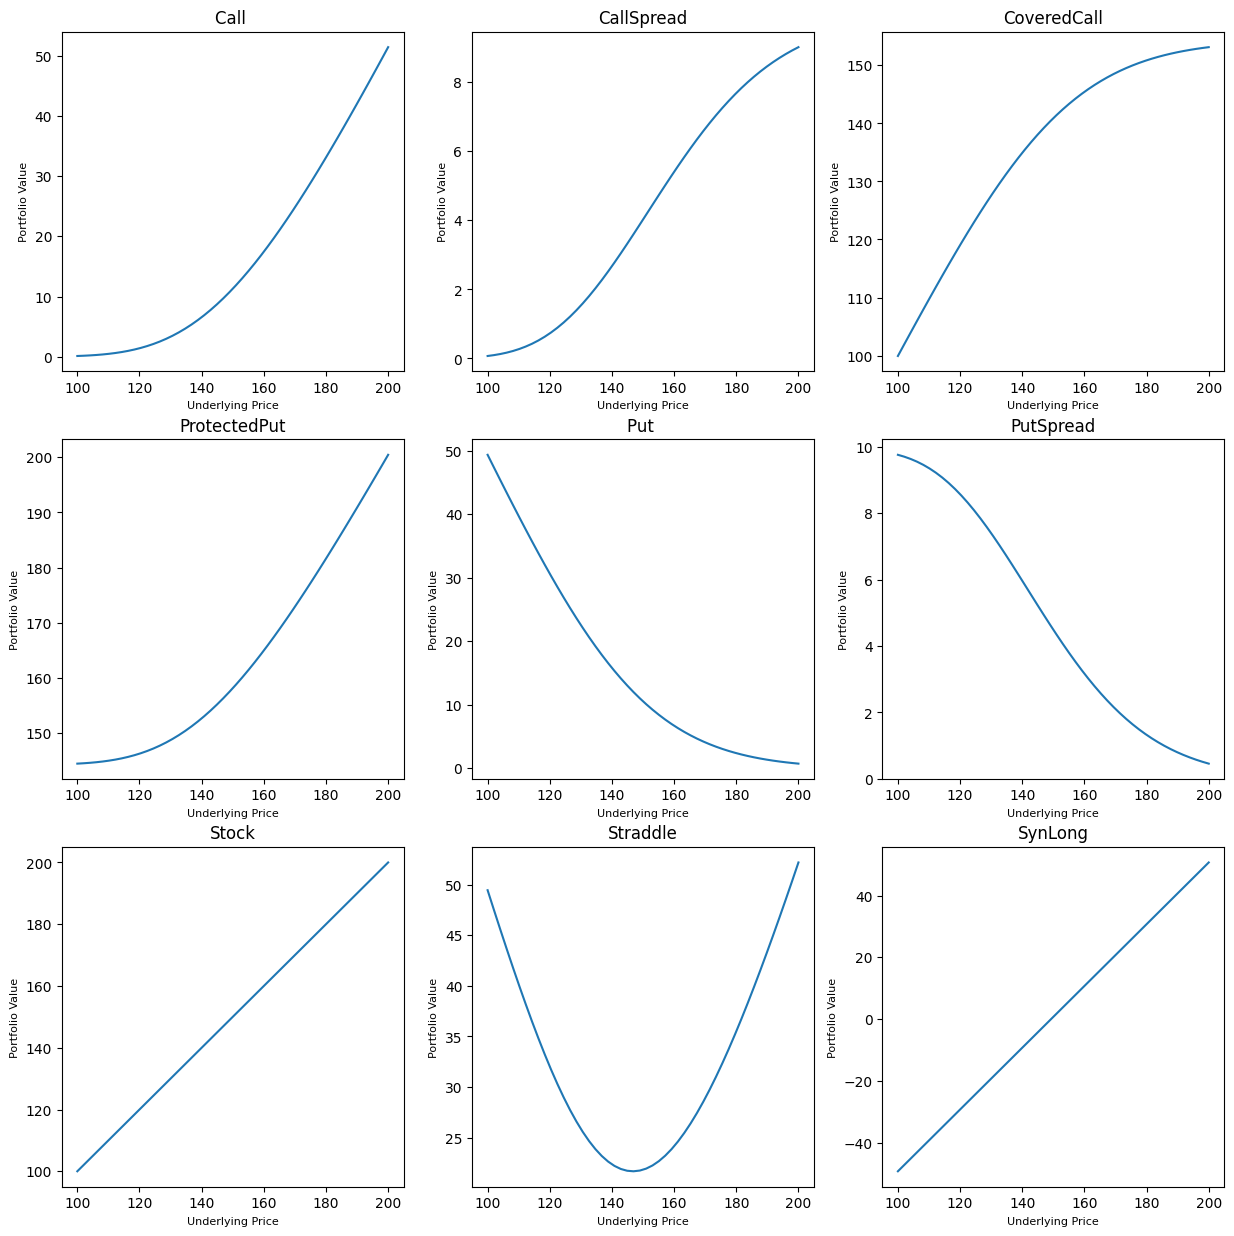

In [71]:
# apply the defined function
sim_p = np.linspace(100, 200, 50)
simulated_vals = sim_portfolio_value(portfolio, sim_p, ivol, rf, b)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
idx = 0
for portfolios, dataframes in simulated_vals.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    ax.plot(sim_p, dataframes.iloc[0, :].values)
    ax.set_title(portfolios)
    ax.set_xlabel('Underlying Price', fontsize=8)
    ax.set_ylabel('Portfolio Value', fontsize=8)
    idx += 1


In [73]:
### PART 2 ###
# read in prices data
prices = pd.read_csv("DailyPrices.csv")
lreturns = RM.return_calculate(prices,method="LOG",dateColumn="Date")
aapl_lreturns = lreturns["AAPL"]
aapl_lreturns = aapl_lreturns - aapl_lreturns.mean()

C:\Users\WANGLIN CAI\fintech545\RiskManagement\return_calculate.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]


In [74]:
aapl_lreturns

1      0.023325
2     -0.000953
3     -0.021062
4     -0.008963
5     -0.017536
         ...   
244    0.024543
245   -0.017655
246    0.019498
247   -0.017374
248   -0.006499
Name: AAPL, Length: 248, dtype: float64

In [182]:
# start fitting returns with AR(1) model
mod = sm.tsa.ARIMA(aapl_lreturns, order=(1, 0, 0))
results = mod.fit()
summary = results.summary()
m = float(summary.tables[1].data[1][1])
a1 = float(summary.tables[1].data[2][1])
s = sqrt(float(summary.tables[1].data[3][1]))
sim = pd.DataFrame(0, index=range(10000), columns=["Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6", "Day 7", "Day 8", "Day 9", "Day 10"])
for i in range(len(sim.columns)):
    for j in range(len(sim)):
        if i == 0:
            sim.iloc[j,i] =  a1 * (aapl_lreturns.iloc[-1]) + np.random.normal(scale = s) + m
        else:
            sim.iloc[j,i] =  a1 * (sim.iloc[j,i-1]) + np.random.normal(scale = s) + m

In [202]:
aapl_lreturns

1      0.022888
2     -0.001390
3     -0.021499
4     -0.009400
5     -0.017973
         ...   
244    0.024107
245   -0.018091
246    0.019062
247   -0.017810
248   -0.006936
Name: AAPL, Length: 248, dtype: float64

In [197]:
b

0.037200000000000004

In [201]:
bs_model(170, 150, ((datetime(2023,4,15) - datetime(2023,3,3)).days - 10) / 365, rf, b, ivol[0], security_type="call")

23.100758280707524

In [159]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                  248
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 590.665
Date:                Thu, 23 Mar 2023   AIC                          -1175.329
Time:                        03:22:10   BIC                          -1164.789
Sample:                             0   HQIC                         -1171.086
                                - 248                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.33e-06      0.001     -0.001      0.999      -0.003       0.003
ar.L1         -0.0468      0.063     -0.742      0.458      -0.171       0.077
sigma2         0.0005   4.31e-05     11.595      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.95   Prob(JB):                         0.27
Heteroskedasticity (H):               0.96   Skew:                             0.03
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [165]:
sim

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10
0,-0.004595,0.007195,0.007564,-0.044123,0.003142,-0.024644,-0.040870,0.014294,0.001581,-0.011292
1,-0.018707,0.000465,0.006393,0.015822,0.036872,-0.020960,0.038238,0.017713,0.038043,0.026621
2,0.038689,0.016083,0.010120,0.030312,-0.038025,-0.004385,-0.017236,-0.008233,-0.002003,-0.003210
3,0.004188,0.008979,0.002205,-0.018696,-0.012860,0.016124,0.002384,-0.007821,-0.018421,-0.003967
4,-0.004051,-0.056200,0.016849,-0.019498,-0.046836,0.013996,-0.007058,0.026089,-0.035114,-0.006236
...,...,...,...,...,...,...,...,...,...,...
9995,0.005999,-0.009645,-0.032533,0.032566,-0.033068,-0.006283,0.022719,0.005964,-0.008231,0.037468
9996,-0.002513,-0.013374,0.045196,-0.040988,-0.001827,-0.011870,0.013636,-0.004220,-0.045562,0.013728
9997,-0.001356,-0.034130,0.038984,-0.007822,0.020001,-0.017956,-0.023010,0.014075,0.015179,0.014837
9998,-0.023754,0.022555,0.003016,0.012534,-0.048321,0.010562,0.007486,0.039823,-0.028377,-0.009182


In [183]:
# calculate prices on the 10th day from current date
ar1_sim_p = pd.DataFrame(0, index=range(10000), columns=["Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6", "Day 7", "Day 8", "Day 9", "Day 10"])
for i in range(len(ar1_sim_p.columns)):
    if i == 0:
        ar1_sim_p.iloc[:,i] = np.exp(sim.iloc[:,i]) * underlying
    else:
        ar1_sim_p.iloc[:,i] = np.exp(sim.iloc[:,i]) * ar1_sim_p.iloc[:,i-1]
ar1_sim_10p = ar1_sim_p.iloc[:,-1]


In [184]:
underlying

151.03

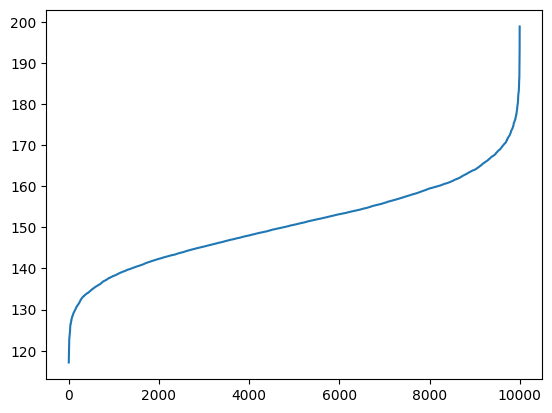

In [185]:
plt.plot(sorted(ar1_sim_10p))

In [186]:
# calculate portfolio values based on the 10th day's simulated prices from AR(1) model
ar1_sim_10port = sim_portfolio_value(portfolio, ar1_sim_10p, ivol, rf, b, day_passed=10)

In [169]:
a = test(portfolio, ar1_sim_10p, ivol, rf, b, day_passed=10)
a

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Portfolio
0,10.337251,41.328943,22.710624,16.555587,8.309526,24.566297,19.186725,22.463410,11.543568,8.549615,...,18.979529,24.430649,30.150195,30.959982,21.762544,14.417340,22.269289,18.193740,15.016587,Straddle
1,9.207583,0.866633,3.437557,5.504225,11.086851,2.992892,4.488370,3.501870,8.289361,10.837804,...,4.560241,3.023252,1.980641,1.865960,3.691276,6.527299,3.553268,4.844671,6.219552,Straddle
2,10.337251,41.328943,22.710624,16.555587,8.309526,24.566297,19.186725,22.463410,11.543568,8.549615,...,18.979529,24.430649,30.150195,30.959982,21.762544,14.417340,22.269289,18.193740,15.016587,SynLong
3,-9.207583,-0.866633,-3.437557,-5.504225,-11.086851,-2.992892,-4.488370,-3.501870,-8.289361,-10.837804,...,-4.560241,-3.023252,-1.980641,-1.865960,-3.691276,-6.527299,-3.553268,-4.844671,-6.219552,SynLong
4,10.337251,41.328943,22.710624,16.555587,8.309526,24.566297,19.186725,22.463410,11.543568,8.549615,...,18.979529,24.430649,30.150195,30.959982,21.762544,14.417340,22.269289,18.193740,15.016587,CallSpread
5,-6.279453,-32.562427,-15.974272,-10.966827,-4.855874,-17.541231,-13.068821,-15.767357,-7.153462,-5.021221,...,-12.901087,-17.425886,-22.388751,-23.106513,-15.183180,-9.306816,-15.605192,-12.268300,-9.767369,CallSpread
6,9.207583,0.866633,3.437557,5.504225,11.086851,2.992892,4.488370,3.501870,8.289361,10.837804,...,4.560241,3.023252,1.980641,1.865960,3.691276,6.527299,3.553268,4.844671,6.219552,PutSpread
7,-4.908983,-0.301351,-1.506407,-2.638579,-6.156959,-1.278884,-2.067842,-1.539838,-4.321201,-5.988264,...,-2.107363,-1.294211,-0.787304,-0.734251,-1.639029,-3.237886,-1.566647,-2.265084,-3.055177,PutSpread
8,150.535272,189.890194,168.688949,160.462587,146.626066,170.990590,164.111645,168.377246,152.661014,147.115479,...,163.832420,170.824488,177.590476,178.515467,167.486469,157.299475,168.131586,162.761595,158.206983,Stock
9,10.337251,41.328943,22.710624,16.555587,8.309526,24.566297,19.186725,22.463410,11.543568,8.549615,...,18.979529,24.430649,30.150195,30.959982,21.762544,14.417340,22.269289,18.193740,15.016587,Call


In [187]:
ar1_sim_10port

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Portfolio,,,,,,,,,,,,,,,,,,,,,
Call,15.919808,5.022887,8.766393,6.876503,6.810099,7.058242,13.871704,10.233649,13.519435,4.803842,...,22.811124,4.667808,7.055550,15.267100,7.399518,10.103026,12.166332,28.618342,13.532048,5.125683
CallSpread,5.451323,2.328730,3.595108,2.987785,2.965332,3.048827,4.980928,4.028359,4.895536,2.246050,...,6.752608,2.194141,3.047927,5.306097,3.161872,3.991032,4.554423,7.577685,4.898617,2.367154
CoveredCall,146.542856,135.116249,140.765096,138.301882,138.203179,138.567204,145.271282,142.316843,145.028348,134.667313,...,149.555818,134.378737,138.563324,146.161863,139.047293,142.188929,144.017372,151.142892,145.037182,135.320600
ProtectedPut,163.656207,151.109995,155.572653,153.347757,153.268636,153.563944,161.384679,157.269027,160.990991,150.841055,...,171.124944,150.673485,153.560746,162.935368,153.968542,157.118970,159.469742,177.267350,161.005103,151.235841
Put,5.787452,15.596994,10.619733,12.763831,12.850636,12.530820,6.823495,9.292574,7.023380,16.001216,...,3.411771,16.261659,12.534224,6.096019,12.110425,9.401235,7.861494,2.217373,7.016102,15.413385
PutSpread,2.985310,6.227179,4.778372,5.446179,5.471767,5.376954,3.407860,4.328430,3.486765,6.329885,...,1.918732,6.394956,5.377971,3.113605,5.250041,4.366385,3.808914,1.318726,3.483906,6.179832
Stock,159.543060,138.824867,147.550574,143.514301,143.361006,143.929286,156.457165,150.346572,155.904698,138.201247,...,168.815305,137.804545,143.923187,158.581241,144.691389,150.107153,153.712241,175.820888,155.924601,139.111435
Straddle,21.707260,20.619881,19.386125,19.640334,19.660735,19.589062,20.695199,19.526223,20.542815,20.805058,...,26.222895,20.929467,19.589774,21.363119,19.509943,19.504262,20.027826,30.835715,20.548149,20.539067
SynLong,10.132356,-10.574108,-1.853340,-5.887328,-6.040537,-5.472578,7.048209,0.941075,6.496054,-11.197374,...,19.399352,-11.593852,-5.478673,9.171081,-4.710907,0.701791,4.304838,26.400969,6.515946,-10.287702


In [120]:
portfolio

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,2023-04-21,150.0,6.80
1,Straddle,Option,AAPL,1,Put,2023-04-21,150.0,4.85
2,SynLong,Option,AAPL,1,Call,2023-04-21,150.0,6.80
3,SynLong,Option,AAPL,-1,Put,2023-04-21,150.0,4.85
4,CallSpread,Option,AAPL,1,Call,2023-04-21,150.0,6.80
5,CallSpread,Option,AAPL,-1,Call,2023-04-21,160.0,2.21
6,PutSpread,Option,AAPL,1,Put,2023-04-21,150.0,4.85
7,PutSpread,Option,AAPL,-1,Put,2023-04-21,140.0,1.84
8,Stock,Stock,AAPL,1,NaN,NaT,NaN,151.03
9,Call,Option,AAPL,1,Call,2023-04-21,150.0,6.80


In [188]:
portfolio["CurrentValue"] = portfolio["CurrentPrice"] * portfolio["Holding"]
curr_values = portfolio.groupby('Portfolio')['CurrentValue'].sum()
sim_value_changes = (ar1_sim_10port.T - curr_values).T
sim_value_changes

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Portfolio,,,,,,,,,,,,,,,,,,,,,
Call,9.119808,-1.777113,1.966393,0.076503,0.010099,0.258242,7.071704,3.433649,6.719435,-1.996158,...,16.011124,-2.132192,0.255550,8.467100,0.599518,3.303026,5.366332,21.818342,6.732048,-1.674317
CallSpread,0.861323,-2.261270,-0.994892,-1.602215,-1.624668,-1.541173,0.390928,-0.561641,0.305536,-2.343950,...,2.162608,-2.395859,-1.542073,0.716097,-1.428128,-0.598968,-0.035577,2.987685,0.308617,-2.222846
CoveredCall,-0.437144,-11.863751,-6.214904,-8.678118,-8.776821,-8.412796,-1.708718,-4.663157,-1.951652,-12.312687,...,2.575818,-12.601263,-8.416676,-0.818137,-7.932707,-4.791071,-2.962628,4.162892,-1.942818,-11.659400
ProtectedPut,9.616207,-2.930005,1.532653,-0.692243,-0.771364,-0.476056,7.344679,3.229027,6.950991,-3.198945,...,17.084944,-3.366515,-0.479254,8.895368,-0.071458,3.078970,5.429742,23.227350,6.965103,-2.804159
Put,0.937452,10.746994,5.769733,7.913831,8.000636,7.680820,1.973495,4.442574,2.173380,11.151216,...,-1.438229,11.411659,7.684224,1.246019,7.260425,4.551235,3.011494,-2.632627,2.166102,10.563385
PutSpread,-0.024690,3.217179,1.768372,2.436179,2.461767,2.366954,0.397860,1.318430,0.476765,3.319885,...,-1.091268,3.384956,2.367971,0.103605,2.240041,1.356385,0.798914,-1.691274,0.473906,3.169832
Stock,8.513060,-12.205133,-3.479426,-7.515699,-7.668994,-7.100714,5.427165,-0.683428,4.874698,-12.828753,...,17.785305,-13.225455,-7.106813,7.551241,-6.338611,-0.922847,2.682241,24.790888,4.894601,-11.918565
Straddle,10.057260,8.969881,7.736125,7.990334,8.010735,7.939062,9.045199,7.876223,8.892815,9.155058,...,14.572895,9.279467,7.939774,9.713119,7.859943,7.854262,8.377826,19.185715,8.898149,8.889067
SynLong,8.182356,-12.524108,-3.803340,-7.837328,-7.990537,-7.422578,5.098209,-1.008925,4.546054,-13.147374,...,17.449352,-13.543852,-7.428673,7.221081,-6.660907,-1.248209,2.354838,24.450969,4.565946,-12.237702


In [189]:
# start calculating mean, VaR, ES for each portfolio
resulting_mat = pd.DataFrame(0, index=ar1_sim_10port.index.values, columns=["Mean of Portfolio Value($)", "Mean of Losses/Gains($)", "VaR($)", "ES($)", "VaR(%)", "ES(%)"])
for i in range(len(resulting_mat)):
    resulting_mat.iloc[i,0] = ar1_sim_10port.iloc[i,:].mean()
    resulting_mat.iloc[i,1] = sim_value_changes.iloc[i,:].mean()
    resulting_mat.iloc[i,2], resulting_mat.iloc[i,3] = RM.cal_VaR_ES_hist(sim_value_changes.iloc[i,:],alpha=0.05)[0:2]
    resulting_mat.iloc[i,4] = resulting_mat.iloc[i,2] * 100 / portfolio.groupby('Portfolio').sum().iloc[i,-1]
    resulting_mat.iloc[i,5] = resulting_mat.iloc[i,3] * 100 / portfolio.groupby('Portfolio').sum().iloc[i,-1]
resulting_mat["Current Value (on 2023/3/3)"] = portfolio.groupby('Portfolio').sum()["CurrentPrice"]

C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_54064\807632485.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resulting_mat.iloc[i,4] = resulting_mat.iloc[i,2] * 100 / portfolio.groupby('Portfolio').sum().iloc[i,-1]
C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_54064\807632485.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resulting_mat.iloc[i,5] = resulting_mat.iloc[i,3] * 100 / portfolio.groupby('Portfolio').sum().iloc[i,-1]
C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_54064\807632485.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a fut

In [190]:
resulting_mat

,Mean of Portfolio Value($),Mean of Losses/Gains($),VaR($),ES($),VaR(%),ES(%),Current Value (on 2023/3/3)
Call,11.355575,4.555575,3.085659,3.962857,45.377338,58.277311,6.80
CallSpread,4.134201,-0.455799,2.772617,3.149916,60.405591,68.625618,9.01
CoveredCall,141.831821,-5.148179,14.874576,17.788442,10.120136,12.102628,155.08
ProtectedPut,158.401150,4.361150,4.554060,5.680255,2.956414,3.687520,154.04
Put,9.817765,4.967765,1.335171,2.162677,27.529291,44.591283,4.85
PutSpread,4.339270,1.329270,1.041760,1.457064,34.609971,48.407440,6.69
Stock,150.943645,-0.086355,16.248282,19.831394,10.758314,13.130765,151.03
Straddle,21.173340,9.523340,-7.742974,-7.738262,-66.463299,-66.422854,11.65
SynLong,1.537810,-0.412190,16.564968,20.146051,849.485516,1033.130806,11.65


In [97]:
portfolio.groupby('Portfolio').sum().iloc[:,-1]

C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_54064\3285908780.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  portfolio.groupby('Portfolio').sum().iloc[:,-1]


Portfolio
Call              6.80
CallSpread        9.01
CoveredCall     155.08
ProtectedPut    154.04
Put               4.85
PutSpread         6.69
Stock           151.03
Straddle         11.65
SynLong          11.65
Name: CurrentPrice, dtype: float64